In [1]:
import numpy as np
import pandas as pd
import os
import gym
import random
from gym import spaces
import torch
import matplotlib.pyplot as plt
from Environment import DiagnosisEnv
from Agent import train_DQN

In [2]:
df_symptoms = pd.read_csv("Data/Symptoms.csv")
df_exams = pd.read_csv("Data/Examinations.csv")
df_emergency_diagnoses = pd.read_csv("Data/Emergency_Diagnosis.csv")

In [3]:
env = DiagnosisEnv(df_symptoms, df_exams, df_emergency_diagnoses)
agent, rewards, success_rates, examinations_per_diagnosis = train_DQN(env, episodes=5000)

C:\Users\jerem\Project_Hospital\Agent.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return (torch.tensor(state, dtype=torch.float32),


In [4]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

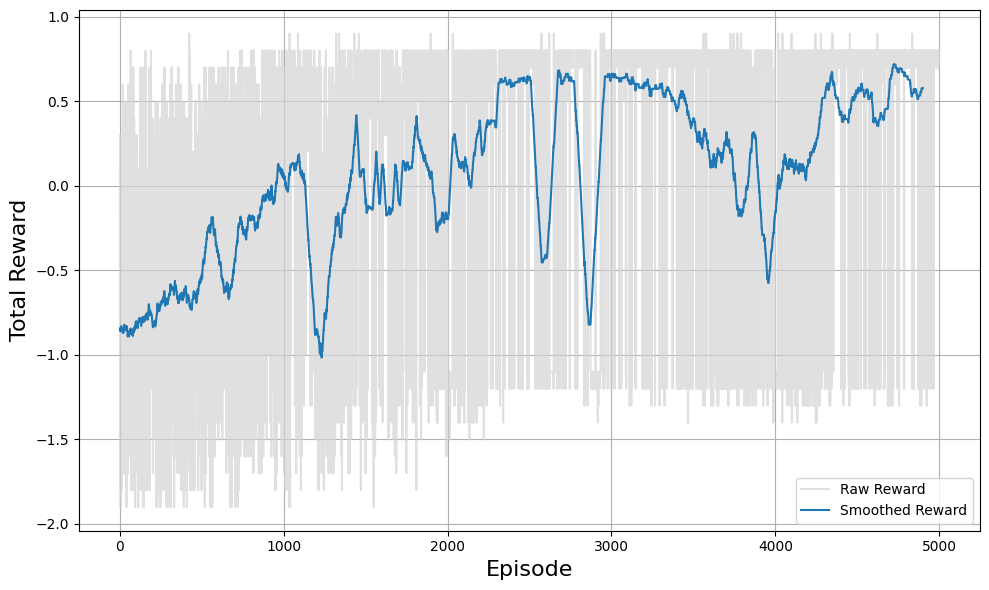

In [17]:
smoothed_rewards = moving_average(rewards, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(rewards, color="lightgray", label="Raw Reward", alpha=0.7)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Total Reward", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

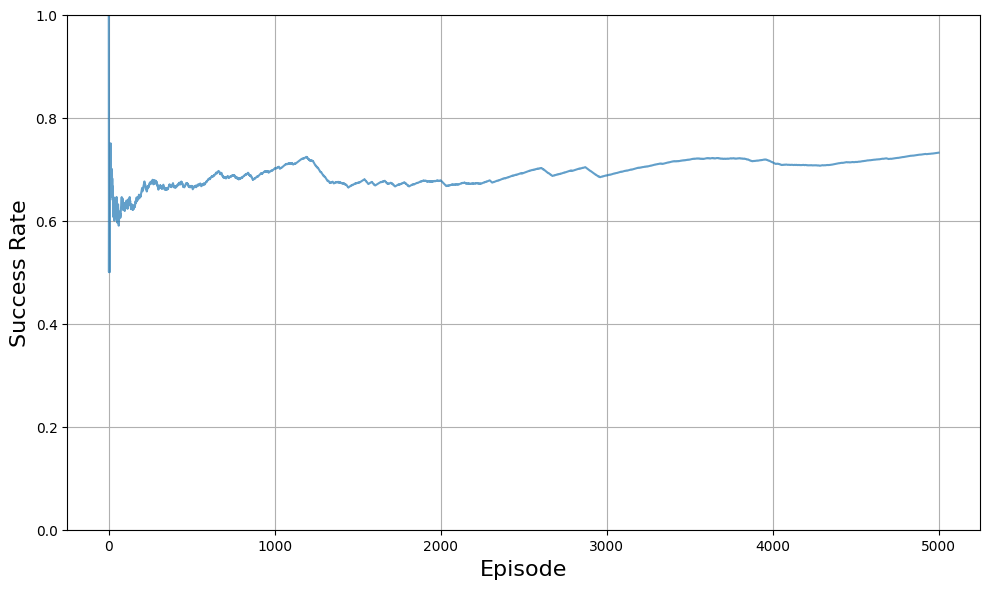

Diagnosis Success Rate: 73.18%


In [18]:
plt.figure(figsize=(10,6))
plt.plot(success_rates, alpha=0.7)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Success Rate", fontsize=16)
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Diagnosis Success Rate: " + str(round(success_rates[-1] * 100,2)) + "%")

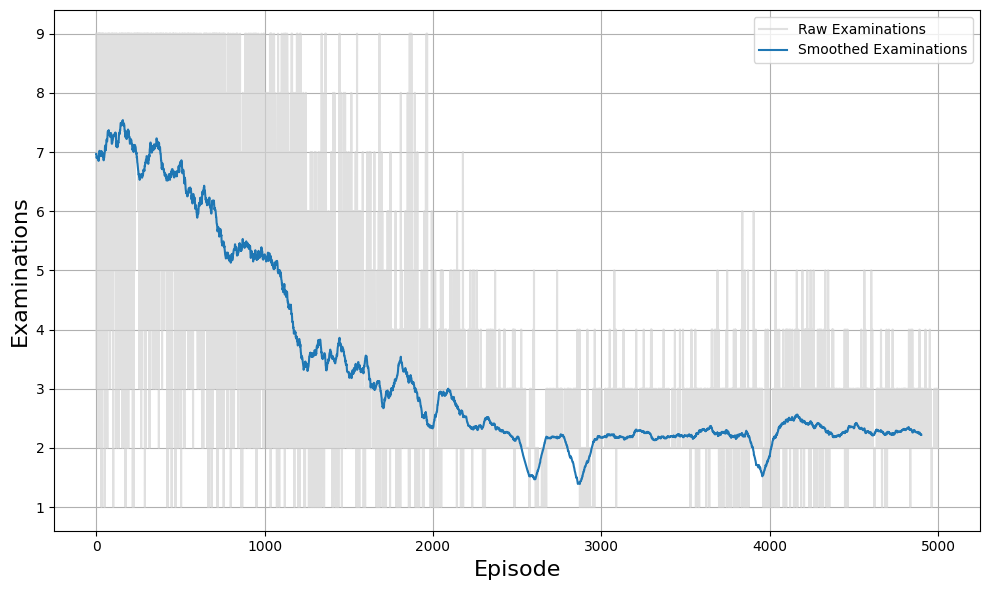

Average Examination per Diagnosis: 2.22


In [19]:
smoothed_examinations = moving_average(examinations_per_diagnosis, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(examinations_per_diagnosis, color="lightgray", label="Raw Examinations", alpha=0.7)
plt.plot(range(len(smoothed_examinations)), smoothed_examinations, label="Smoothed Examinations")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Examinations", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Average Examination per Diagnosis: " + str(round(smoothed_examinations[-1],2)))

In [13]:
def test_agent(env, agent, num_patients=10):
    number_of_diagnoses = len(df_emergency_diagnoses)
    print("Emergency Department, Number of possible Diagnosis: " + str(number_of_diagnoses))
    overall_correct_diagnoses = 0
    for num in range(number_of_diagnoses):
        correct_diagnoses = 0
        for patient_num in range(num_patients):
            state = env.set(num)
    
            exams_taken = []
            symptoms_history = []
    
            done = False
            step_count = 0
    
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent(state_tensor).squeeze()
                action = q_values.argmax().item()
                exam_taken = env.examinations[action]
    
                state, reward, done, info = env.step(action)
                observed_symptoms = env.get_observed_symptoms()
    
                exams_taken.append(exam_taken)
                symptoms_history.append(observed_symptoms)
    
                if info.get("forced", False):
                    if info["guess"] == info["diagnosis"]:
                        correct_diagnoses += 1
                        overall_correct_diagnoses += 1
                    break
    
                step_count += 1
    
        accuracy = correct_diagnoses / num_patients
        print(df_emergency_diagnoses.loc[num,'Diagnosis'].capitalize() + " - Accuracy over " + str(num_patients) + " patients: " + str(accuracy))
    print("Emergency Department - Overall Accuracy: " + str(round(overall_correct_diagnoses / (num_patients * number_of_diagnoses) * 100,2)) + "%")

In [20]:
test_agent(env, agent, num_patients=100)

Emergency Department, Number of possible Diagnosis: 30
Ankle contusion - Accuracy over 100 patients: 1.0
Arm contusion - Accuracy over 100 patients: 1.0
Athlete's foot - Accuracy over 100 patients: 1.0
Bacterial tonsillitis - Accuracy over 100 patients: 1.0
Beef tapeworm - Accuracy over 100 patients: 1.0
Bronchitis - Accuracy over 100 patients: 1.0
Chest contusion - Accuracy over 100 patients: 0.97
Chickenpox - Accuracy over 100 patients: 1.0
Chronic fatigue syndrome - Accuracy over 100 patients: 1.0
Common cold - Accuracy over 100 patients: 1.0
Contact dermatitis - Accuracy over 100 patients: 0.97
Foot contusion - Accuracy over 100 patients: 0.98
Golfers elbow - Accuracy over 100 patients: 0.99
Hand contusion - Accuracy over 100 patients: 1.0
Hay fever - Accuracy over 100 patients: 1.0
Influenza - Accuracy over 100 patients: 1.0
Influenza b - Accuracy over 100 patients: 0.0
Insomnia - Accuracy over 100 patients: 0.85
Iron-deficiency anemia - Accuracy over 100 patients: 0.98
Lactose in

In [15]:
def test_diagnosis(env, agent, diagnosis, num_patients=5):
    int_diagnosis = int(df_emergency_diagnoses.index[df_emergency_diagnoses["Diagnosis"] == diagnosis].tolist()[0])
    correct_diagnoses = 0
    for patient_num in range(num_patients):
        state = env.set(int_diagnosis)

        print("\nPATIENT " + str(patient_num + 1))
        print("TRUE DIAGNOSIS: " + str(env.get_true_diagnosis()))
        print("TRUE SYMPTOMS (Generated for this patient): " + str(env.get_true_symptoms()) + "\n")

        exams_taken = []
        symptoms_history = []

        done = False
        step_count = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor).squeeze()
            action = q_values.argmax().item()
            exam_taken = env.examinations[action]

            state, reward, done, info = env.step(action)
            observed_symptoms = env.get_observed_symptoms()

            exams_taken.append(exam_taken)
            symptoms_history.append(observed_symptoms)

            if info.get("forced", False):
                print("\nGuessed Diagnosis: " + str(info['guess'].capitalize()))
                if info["guess"] == info["diagnosis"]:
                    correct_diagnoses += 1
                break
                
            print("Step " + str(step_count + 1))
            print("Examination taken: " + str(exam_taken))
            print("Symptoms uncovered so far: " + str(observed_symptoms))

            step_count += 1
    
    accuracy = correct_diagnoses / num_patients
    print(str(diagnosis.capitalize()) + ": Accuracy over " + str(num_patients) + " patients: " + str(accuracy))

In [16]:
test_diagnosis(env, agent, "influenza b", 5)


PATIENT 1
TRUE DIAGNOSIS: influenza b
TRUE SYMPTOMS (Generated for this patient): ['fatigue', 'headache', 'irritable cough', 'malaise', 'muscle and joint pain', 'nasal congestion', 'sneezing', 'sore throat', 'influenza b detected']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['fatigue', 'headache', 'irritable cough', 'malaise', 'muscle and joint pain', 'nasal congestion', 'sneezing', 'sore throat']
Step 2
Examination taken: ct enterography
Symptoms uncovered so far: ['fatigue', 'headache', 'irritable cough', 'malaise', 'muscle and joint pain', 'nasal congestion', 'sneezing', 'sore throat']

Guessed Diagnosis: Influenza

PATIENT 2
TRUE DIAGNOSIS: influenza b
TRUE SYMPTOMS (Generated for this patient): ['chills', 'fatigue', 'fever', 'headache', 'irritable cough', 'malaise', 'muscle and joint pain', 'nasal congestion', 'sore throat', 'influenza b detected']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['chills', 'fatigue', 'fever', 'headache', 'irri